In [2]:
import numpy as np
from qutip import *
import os
from matplotlib import pyplot as plt
import sys
import pickle
from scipy.integrate import solve_ivp

In [3]:
def lindblad_term(rho, a):
    return a@rho@np.conj(a.T) - .5*(np.conj(a.T)@a@rho + rho@np.conj(a.T)@a)

def commutator(A, B):
    return A@B - B@A

def lindblad_master_equation(t, rho_vec, hamiltonian, dissipation_channels):
    d = int(len(rho_vec)**.5)
    rho = rho_vec.reshape(d, d)
    drho = -1j*commutator(hamiltonian,rho) + np.sum([lindblad_term(rho, i) for i in dissipation_channels], axis=0)
    return drho.flatten()
    # if callable(hamiltonian):
    #     return commutator(hamiltonian(t),rho) + np.sum([lindblad_term(rho, i) for i in dissipation_channels], axis=0)
    # else


In [46]:
cavity_diss_rate = 2*np.pi*4.3*10**6
input_power = 0
cavity_photon_number = 10**(input_power/10)
rabi_freq = 2*np.pi*9*10**6
qubit_detuning =  2*np.pi*0*10**6
eff_coupling = 2*np.pi*(1)*10**6

qubit_detuning_lamb_shift_ss = qubit_detuning + eff_coupling*(2*cavity_photon_number + 1)
cavity_detuning = -(qubit_detuning_lamb_shift_ss**2 + rabi_freq**2)**.5
cavity_drive_amplitude = np.real((cavity_photon_number * (cavity_detuning**2 + .25*cavity_diss_rate**2))**.5)

cavity_field_e = cavity_drive_amplitude/(-(cavity_detuning + eff_coupling) + .5j*cavity_diss_rate)
cavity_field_g = cavity_drive_amplitude/(-(cavity_detuning - eff_coupling) + .5j*cavity_diss_rate)
qubit_dissipation_rate = 2*eff_coupling*np.imag(cavity_field_g*np.conj(cavity_field_e))
qubit_detuning_lamb_shift = qubit_detuning + eff_coupling*(2*np.real(cavity_field_g*np.conj(cavity_field_e)) + 1)
qubit_targetz = qubit_detuning + qubit_detuning_lamb_shift

norm = 2*np.pi*10**6
final_time = 50 # in 1/Mhz
tlist = np.linspace(0, final_time, 10000)/(10**6)

tlist__N = tlist*norm
qubit_detuning_lamb_shift__N = qubit_detuning_lamb_shift/norm
qubit_dissipation_rate__N = qubit_dissipation_rate/norm
rabi_freq__N = rabi_freq/norm

sz = sigmaz().full()
sx = sigmax().full()  
sm = sigmam().full()


H_qubit = .5*qubit_detuning_lamb_shift__N*sz + .5*rabi_freq__N*sx



dissipation_channels = [(qubit_dissipation_rate__N**.5*sz)]

initial_state = basis(2,1)
rho0 = initial_state@initial_state.dag()
rho0_matrix = rho0.full()
rho0_vectorized = rho0_matrix.flatten()


max_step =  0.05/np.max([qubit_detuning_lamb_shift__N,
                        rabi_freq__N, qubit_dissipation_rate__N])

sol = solve_ivp(lindblad_master_equation, (tlist__N[0], tlist__N[-1]), rho0_vectorized, method="DOP853", t_eval=tlist__N, 
                max_step=max_step, args=(H_qubit, dissipation_channels))

dynamics = sol.y.T.reshape(10000, 2, 2)






In [47]:
cavity_field_g - cavity_field_e,cavity_field_g*np.conj(cavity_field_e), cavity_detuning

((-0.18688662358537067+0.09035272901251237j),
 (1.0085536642541237+0.046321992643784726j),
 -59607529.5947766)

(-1.0, 1.0)

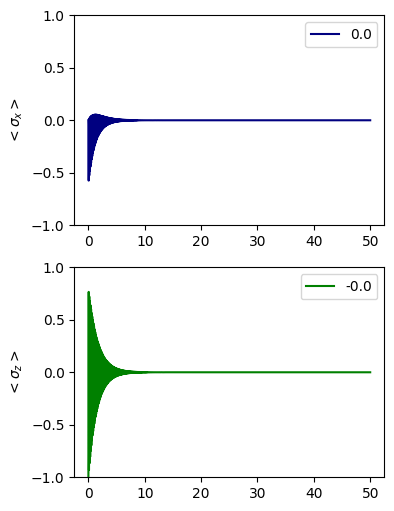

In [48]:
z = np.trace(dynamics@sz, axis1=1, axis2=2)
x = np.trace(dynamics@sx, axis1=1, axis2=2)

xmean = np.mean(x[-20:])
zmean = np.mean(z[-20:])

#Create the figures.
fig, axes = plt.subplots(2, 1, figsize=(4,6))

#fig.suptitle(fig_title)

axes[0].plot(tlist*10**6, x, color='#000080', label= f"{round(np.real(xmean),2)}")
#axes[0].set_xlabel('Time (1/Mhz)')
axes[0].set_ylabel(r'$ <\sigma_x >$')
axes[0].legend()
axes[0].set_ylim(-1, 1)

axes[1].plot(tlist*10**6, z, color='#008000', label= f"{round(np.real(zmean),2)}")
#axes[1].set_xlabel('Time (1/Mhz)')
axes[1].set_ylabel(r'$<\sigma_z >$')
axes[1].legend()
axes[1].set_ylim(-1, 1)


In [ ]:
import numpy as np
from qutip import *
import os
from matplotlib import pyplot as plt
import sys
from scipy.integrate import solve_ivp
import pickle
from datetime import datetime



def redfield_master_equation(t, rho_vec, hamiltonian, Z_operators, S_operators):
    d = int(len(rho_vec)**.5)
    rho = rho_vec.reshape(d, d)
    
    Z_conj = np.conj(Z_operators)
    
    term1 = np.einsum('nij,jk,nkl->il', Z_operators, rho, S_operators)
    term2 = np.einsum('nij,jk,nlk->il', S_operators, rho, Z_conj)
    term3 = np.einsum('nij,njk,kl->il', S_operators, Z_operators, rho)  
    term4 = np.einsum('ij,nkj,nkl->il', rho, Z_conj, S_operators)     
    
    redfield_part = term1 + term2 - term3 - term4

    coherent_part = -1j*(np.einsum('ij,jk',hamiltonian, rho) - np.einsum('ij,jk', rho, hamiltonian))
    
    drho = coherent_part + redfield_part
    return drho.flatten()

def lindblad_master_equation(t, rho_vec, hamiltonian, L_operators):
    d = int(len(rho_vec)**.5)
    rho = rho_vec.reshape(d, d)

    L_conj = np.conj(L_operators)

    term1 = np.einsum('nij, jk, nlk', L_operators, rho, L_conj)
    term2 = np.einsum('nji, njk, kl', L_conj, L_operators, rho)
    term3 = np.einsum('ij, nkj, nkl', rho, L_conj, L_operators)

    lindblad_part = term1 - .5*(term2 + term3)

    coherent_part = -1j*(np.einsum('ij,jk',hamiltonian, rho) - np.einsum('ij,jk', rho, hamiltonian))

    drho = coherent_part + lindblad_part
    return drho.flatten()

def calculate_full_dynamics(parameters):
    
    #Retrieve needed parameters from the dictionary.
    N = parameters['N']
    cavity_diss_rate = parameters['cavity_diss_rate']
    input_power = parameters['input_power']
    rabi_freq = parameters['rabi_freq']
    eff_coupling = parameters['eff_coupling']
    qubit_targetz = parameters['qubit_targetz']
    norm = parameters['norm']
    final_time__mus = parameters['final_time__mus'] 
    time_steps = parameters["time_steps"]
    psi0_atom = parameters['initial_state_qubit']

    #Calculate important parameters
    cavity_photon_number = 10**(input_power/10)
    qubit_detuning = qubit_targetz + eff_coupling*(2*cavity_photon_number + 1) 
    qubit_detuning_lamb_shift = qubit_detuning - eff_coupling*(2*cavity_photon_number + 1)
    cavity_detuning = (qubit_detuning_lamb_shift**2 + rabi_freq**2)**.5
    cavity_drive_amplitude = np.real((cavity_photon_number * (cavity_detuning**2 + .25*cavity_diss_rate**2))**.5)
    cavity_field = cavity_drive_amplitude/(-cavity_detuning + .5j*cavity_diss_rate)
    tlist = np.linspace(0, final_time__mus, time_steps)/(10**6)

    #Norm everything
    tlist__N = tlist*norm
    cavity_detuning__N = cavity_detuning/norm
    cavity_drive_amplitude__N = cavity_drive_amplitude/norm
    qubit_detuning__N = qubit_detuning/norm
    eff_coupling__N = eff_coupling/norm
    rabi_freq__N = rabi_freq/norm
    cavity_diss_rate__N = cavity_diss_rate/norm
    qubit_detuning_lamb_shift__N = qubit_detuning_lamb_shift/norm

    ### HAMILTONIAN 7 ####
    d = tensor(destroy(N), qeye(2))   
    sz = tensor(qeye(N), sigmaz())  
    sx = tensor(qeye(N), sigmax())     
    sm = tensor(qeye(N), sigmam()) 

    H_cav = cavity_detuning__N * d.dag()*d + cavity_drive_amplitude__N * (d + d.dag())
    H_qubit = -.5*(qubit_detuning__N - eff_coupling__N)*sz - .5*rabi_freq__N*sx
    H_int =   eff_coupling__N*d.dag()*d*sz
    H = H_cav + H_qubit + H_int

    H_matrix = H.full()
    d_matrix = d.full()


    dissipation_channels = [(cavity_diss_rate__N**.5*d_matrix)]

    psi0_cavity = coherent(N,cavity_field)
    initial_state = tensor(psi0_cavity, psi0_atom)
    rho0 = initial_state@initial_state.dag()
    rho0_matrix = rho0.full()
    rho0_vectorized = rho0_matrix.flatten()

    max_step =  0.05/np.max([cavity_drive_amplitude__N, qubit_detuning__N, cavity_detuning__N,
                            rabi_freq__N, eff_coupling__N, cavity_diss_rate__N])

    sol = solve_ivp(lindblad_master_equation, (tlist__N[0], tlist__N[-1]), rho0_vectorized, method="DOP853",
                     t_eval=tlist__N, max_step=max_step, args=(H_matrix, dissipation_channels))

    full_dynamics = sol.y.T.reshape(time_steps, 2*N, 2*N)

    dynamics = [Qobj(i, dims=[[N, 2], [N, 2]]) for i in full_dynamics]

    return dynamics

def calculate_redfield_dynamics(parameters):

    #Retrieve needed parameters from the dictionary.
    N = parameters['N']
    cavity_diss_rate = parameters['cavity_diss_rate']
    input_power = parameters['input_power']
    rabi_freq = parameters['rabi_freq']
    eff_coupling = parameters['eff_coupling']
    qubit_targetz = parameters['qubit_targetz']
    norm = parameters['norm']
    final_time__mus = parameters['final_time__mus'] 
    time_steps = parameters["time_steps"]
    psi0_atom = parameters['initial_state_qubit']

    #Calculate important parameters
    cavity_photon_number = 10**(input_power/10)
    qubit_detuning = qubit_targetz + eff_coupling*(2*cavity_photon_number + 1) 
    qubit_detuning_lamb_shift = qubit_detuning - eff_coupling*(2*cavity_photon_number + 1)
    cavity_detuning = (qubit_detuning_lamb_shift**2 + rabi_freq**2)**.5
    cavity_drive_amplitude = np.real((cavity_photon_number * (cavity_detuning**2 + .25*cavity_diss_rate**2))**.5)
    cavity_field = cavity_drive_amplitude/(-cavity_detuning + .5j*cavity_diss_rate)
    tlist = np.linspace(0, final_time__mus, time_steps)/(10**6)
    diag_qubit_freq = (qubit_detuning_lamb_shift**2 + rabi_freq**2)**.5
    coupling_sz = eff_coupling*qubit_detuning_lamb_shift/diag_qubit_freq
    coupling_sx = -eff_coupling*rabi_freq/diag_qubit_freq

    #Norm everything
    tlist__N = tlist*norm
    cavity_detuning__N = cavity_detuning/norm
    cavity_drive_amplitude__N = cavity_drive_amplitude/norm
    qubit_detuning__N = qubit_detuning/norm
    eff_coupling__N = eff_coupling/norm
    rabi_freq__N = rabi_freq/norm
    cavity_diss_rate__N = cavity_diss_rate/norm
    qubit_detuning_lamb_shift__N = qubit_detuning_lamb_shift/norm
    diag_qubit_freq__N = diag_qubit_freq/norm
    coupling_sz__N = coupling_sz/norm
    coupling_sx__N = coupling_sx/norm



    ### Qubit Hamiltonian ###
    sz = sigmaz()
    sx = sigmax()
    sm = sigmap()

    sz_matrix = sz.full()
    sx_matrix = sx.full()
    sm_matrix = sm.full()
    H_qubit_matrix = -.5*diag_qubit_freq__N*sz_matrix

    ### Redfield operators ###
    u1 = (cavity_photon_number*coupling_sz__N/(-1j*cavity_detuning__N + cavity_diss_rate__N/2)*sz_matrix \
        +  cavity_photon_number*coupling_sx__N/(1j*(-diag_qubit_freq__N - cavity_detuning__N) + cavity_diss_rate__N/2)*sm_matrix.T \
        +  cavity_photon_number*coupling_sx__N/(1j*(diag_qubit_freq__N - cavity_detuning__N) + cavity_diss_rate__N/2)*sm_matrix )

    s1 = coupling_sz__N*sz_matrix + coupling_sx__N*sx_matrix

    U = unitary_diag_qubit_hamiltonian(parameters)

    rho0 = U*psi0_atom@psi0_atom.dag()*U.dag()
    rho0_matrix = rho0.full()
    rho0_vectorized = rho0_matrix.flatten()
    max_step =  0.05/np.max([diag_qubit_freq__N, coupling_sz__N, coupling_sx__N,])

    sol = solve_ivp(redfield_master_equation, (tlist__N[0], tlist__N[-1]), rho0_vectorized, method="DOP853",
                    t_eval=tlist__N, max_step=max_step, args=(H_qubit_matrix, [u1], [s1]))

    full_dynamics = sol.y.T.reshape(time_steps, 2, 2)

    dynamics = [U.dag()*Qobj(i, dims=[[2], [2]])*U for i in full_dynamics]
    return dynamics


def target_hamiltonian(parameters):

    input_power = parameters['input_power']
    rabi_freq = parameters['rabi_freq']
    eff_coupling = parameters['eff_coupling']
    qubit_targetz = parameters['qubit_targetz']
    norm = parameters['norm']

    #Calculate important parameters
    cavity_photon_number = 10**(input_power/10)
    qubit_detuning = qubit_targetz + eff_coupling*(2*cavity_photon_number + 1) 
    qubit_detuning_lamb_shift = qubit_detuning - eff_coupling*(2*cavity_photon_number + 1)
    rabi_freq__N = rabi_freq/norm
    qubit_detuning_lamb_shift__N = qubit_detuning_lamb_shift/norm

    H_qubit_target = -.5*(qubit_detuning_lamb_shift__N*sigmaz() + rabi_freq__N*sigmax())
    return H_qubit_target

def unitary_diag_qubit_hamiltonian(parameters):
    """
    Returns U = exp(i * θ/2 * σ_y) that diagonlizes the qubit Hamiltonian
    """

    #Retrieve needed parameters from the dictionary.
    input_power = parameters['input_power']
    rabi_freq = parameters['rabi_freq']
    eff_coupling = parameters['eff_coupling']
    qubit_targetz = parameters['qubit_targetz']


    #Calculate important parameters
    cavity_photon_number = 10**(input_power/10)
    qubit_detuning = qubit_targetz + eff_coupling*(2*cavity_photon_number + 1) 
    qubit_detuning_lamb_shift = qubit_detuning - eff_coupling*(2*cavity_photon_number + 1)

    theta = np.arctan2(rabi_freq, qubit_detuning_lamb_shift)

    U = (1j * theta/2 * sigmay()).expm()

    return U

def calculate_rates_dynamics(parameters):

    #Retrieve needed parameters from the dictionary.
    cavity_diss_rate = parameters['cavity_diss_rate']
    input_power = parameters['input_power']
    rabi_freq = parameters['rabi_freq']
    eff_coupling = parameters['eff_coupling']
    qubit_targetz = parameters['qubit_targetz']
    norm = parameters['norm']
    final_time__mus = parameters['final_time__mus'] 
    time_steps = parameters["time_steps"]
    psi0_atom = parameters['initial_state_qubit']


    #Calculate important parameters
    cavity_photon_number = 10**(input_power/10)
    qubit_detuning = qubit_targetz + eff_coupling*(2*cavity_photon_number + 1) 
    qubit_detuning_lamb_shift = qubit_detuning - eff_coupling*(2*cavity_photon_number + 1)
    cavity_detuning = (qubit_detuning_lamb_shift**2 + rabi_freq**2)**.5
    tlist = np.linspace(0, final_time__mus, time_steps)/(10**6)
    diag_qubit_freq = (qubit_detuning_lamb_shift**2 + rabi_freq**2)**.5
    theta = np.arctan2(rabi_freq,qubit_detuning_lamb_shift)
    S_nn_neg = (cavity_photon_number * cavity_diss_rate) / ((cavity_diss_rate/2)**2+(-rabi_freq/np.sin(theta) + cavity_detuning)**2)
    eff_qubit_excitation_rate = eff_coupling**2*S_nn_neg*np.sin(theta)**2
    S_nn_pos = (cavity_photon_number * cavity_diss_rate) / ((cavity_diss_rate/2)**2+(rabi_freq/np.sin(theta) + cavity_detuning)**2)
    eff_qubit_decay_rate = eff_coupling**2*S_nn_pos*np.sin(theta)**2 


    #Norm everything
    tlist__N = tlist*norm
    qubit_detuning_lamb_shift__N = qubit_detuning_lamb_shift/norm
    diag_qubit_freq__N = diag_qubit_freq/norm
    eff_qubit_excitation_rate__N = eff_qubit_excitation_rate/norm
    eff_qubit_decay_rate__N = eff_qubit_decay_rate/norm

    ### Qubit Hamiltonian ###
    sz = sigmaz()
    sx = sigmax()
    sm = sigmam()

    sz_matrix = sz.full()
    sx_matrix = sx.full()
    sm_matrix = sm.full()
    H_qubit_matrix = -.5*diag_qubit_freq__N*sz_matrix

    dissipation_channels = [eff_qubit_excitation_rate__N**.5*sm_matrix.T, eff_qubit_decay_rate__N**.5*sm_matrix]

    U = unitary_diag_qubit_hamiltonian(parameters)

    rho0 = U*psi0_atom@psi0_atom.dag()*U.dag()
    rho0_matrix = rho0.full()
    rho0_vectorized = rho0_matrix.flatten()
    max_step =  0.05/np.max([diag_qubit_freq__N, eff_qubit_excitation_rate__N, eff_qubit_decay_rate__N,])

    sol = solve_ivp(lindblad_master_equation, (tlist__N[0], tlist__N[-1]), rho0_vectorized, method="DOP853",
                     t_eval=tlist__N, max_step=max_step, args=(H_qubit_matrix, dissipation_channels))
    
    full_dynamics = sol.y.T.reshape(time_steps, 2, 2)

    dynamics = [U.dag()*Qobj(i, dims=[[2], [2]])*U for i in full_dynamics]
    return dynamics


# === SAVE DYNAMICS ===
def save_dynamics(full_dynamics, parameters, save_dir="./saved_dynamics"):
    """
    Save the dynamics and parameters to file
    """
    # Create directory if it doesn't exist
    os.makedirs(save_dir, exist_ok=True)
    
    # Create timestamp for unique filename
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    
    # Prepare data to save
    data_to_save = {
        'full_dynamics': full_dynamics,
        'parameters': parameters,
        'timestamp': timestamp,
        'description': f"Dynamics for N={parameters['N']}, κ={parameters['cavity_diss_rate']/(2*np.pi*1e6):.1f}MHz"
    }
    
    # Save as pickle file
    filename = f"dynamics_{timestamp}.pkl"
    filepath = os.path.join(save_dir, filename)
    
    with open(filepath, 'wb') as f:
        pickle.dump(data_to_save, f)
    
    print(f"Dynamics saved to: {filepath}")
    return filepath

# Save the dynamics

# === RECALL DYNAMICS ===
def load_dynamics(filepath):
    """
    Load dynamics from saved file
    """
    with open(filepath, 'rb') as f:
        loaded_data = pickle.load(f)
    
    print(f"Dynamics loaded from: {filepath}")
    print(f"Timestamp: {loaded_data['timestamp']}")
    print(f"Description: {loaded_data['description']}")
    print(f"Parameters: {loaded_data['parameters']}")
    
    return loaded_data['full_dynamics'], loaded_data['parameters']

# Example: Load the dynamics (commented out since we just saved them)
# loaded_dynamics, loaded_parameters = load_dynamics(saved_filepath)

# === ALTERNATIVE: SMART LOADING FUNCTION ===
def load_latest_dynamics(save_dir="./saved_dynamics"):
    """
    Load the most recently saved dynamics file
    """
    if not os.path.exists(save_dir):
        raise FileNotFoundError(f"Directory {save_dir} does not exist")
    
    # Get all .pkl files in the directory
    pkl_files = [f for f in os.listdir(save_dir) if f.endswith('.pkl')]
    
    if not pkl_files:
        raise FileNotFoundError(f"No dynamics files found in {save_dir}")
    
    # Sort by modification time (newest first)
    pkl_files.sort(key=lambda x: os.path.getmtime(os.path.join(save_dir, x)), reverse=True)
    
    # Load the most recent file
    latest_file = os.path.join(save_dir, pkl_files[0])
    return load_dynamics(latest_file)

# Example usage for loading (commented out):
# latest_dynamics, latest_parameters = load_latest_dynamics()

# === CONTINUE WITH YOUR ANALYSIS ===
# Now you can use full_dynamics for your fidelity analysis, or load saved dynamics

# Example: If you want to work with loaded dynamics instead of recalculating:
# full_dynamics, parameters = load_latest_dynamics()  # Uncomment this to use saved data

Dynamics saved to: ./saved_dynamics/dynamics_20251022_151658.pkl


In [117]:
N = 10
cavity_diss_rate = 2*np.pi*4.3*10**6
input_power = 0
rabi_freq = 2*np.pi*9*10**6
eff_coupling = 2*np.pi*(1)*10**6
qubit_targetz = 30*2*np.pi*10**6
norm = eff_coupling
final_time__mus = 2
time_steps = 1000

parameters = {"N":N,
            "final_time__mus": final_time__mus,
            "time_steps": time_steps,
            "input_power": input_power,
            "rabi_freq": rabi_freq,
            "eff_coupling": eff_coupling,
            "qubit_targetz": qubit_targetz,
            "cavity_diss_rate": cavity_diss_rate,
            "norm": norm}

H_qubit_target = target_hamiltonian(parameters)
eigenenergies, eigenstate = H_qubit_target.eigenstates()
psi0_atom = eigenstate[-1]
target_state = eigenstate[0]

parameters["initial_state_qubit"] = psi0_atom

full_dynamics = calculate_full_dynamics(parameters)

saved_filepath = save_dynamics(full_dynamics, parameters)

Dynamics saved to: ./saved_dynamics/dynamics_20251022_163858.pkl


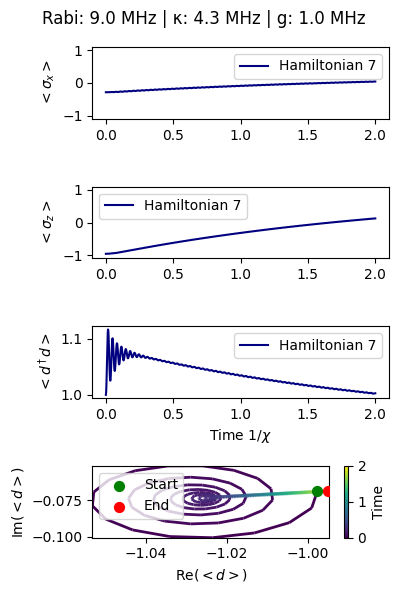

In [118]:
from matplotlib.collections import LineCollection

d = tensor(destroy(N), qeye(2))   
sz = tensor(qeye(N), sigmaz())  
sx = tensor(qeye(N), sigmax())     

x_hamiltonian7 = expect(sx, full_dynamics)
z_hamiltonian7 = expect(sz, full_dynamics)
photon_number = expect(d.dag()*d, full_dynamics)
d_exp = expect(d, full_dynamics)

tlist = np.linspace(0, final_time__mus, time_steps)

fig, axes = plt.subplots(4, 1, figsize=(4,6))

axes[0].plot(tlist, x_hamiltonian7, color='#000080', label= f"Hamiltonian 7")
axes[0].set_ylabel(r'$ <\sigma_x >$')
axes[0].legend()
axes[0].set_ylim(-1.1, 1.1)

axes[1].plot(tlist, z_hamiltonian7, color='#000080', label= f"Hamiltonian 7")
axes[1].set_ylabel(r'$<\sigma_z >$')
axes[1].legend()
axes[1].set_ylim(-1.1, 1.1)

axes[2].plot(tlist, photon_number, color='#000080', label= f"Hamiltonian 7")
axes[2].set_xlabel(r'Time $1/\chi$')
axes[2].set_ylabel(r'$<d^\dagger d>$')
axes[2].legend()

# Create a colored line for the phase space plot showing time evolution
x = np.real(d_exp)
y = np.imag(d_exp)

# Create segments for LineCollection
points = np.array([x, y]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)

# Create a LineCollection object with colors based on time
norm = plt.Normalize(tlist.min(), tlist.max())
lc = LineCollection(segments, cmap='viridis', norm=norm)
lc.set_array(tlist[:-1])  # Use time as color array
lc.set_linewidth(2)

# Plot the line collection
line = axes[3].add_collection(lc)
axes[3].set_xlim(x.min(), x.max())
axes[3].set_ylim(y.min(), y.max())
axes[3].set_xlabel(r'Re($<d >$)')
axes[3].set_ylabel(r'Im($<d >$)')

# Add colorbar to show time progression
cbar = plt.colorbar(line, ax=axes[3])
cbar.set_label('Time')

# Add start and end markers
axes[3].scatter(x[0], y[0], color='green', s=50, zorder=3, label='Start')
axes[3].scatter(x[-1], y[-1], color='red', s=50, zorder=3, label='End')
axes[3].legend()

params_text = []
params_text.append(f"Rabi: {rabi_freq/(2*np.pi*1e6):.1f} MHz")
params_text.append(f"κ: {cavity_diss_rate/(2*np.pi*1e6):.1f} MHz")
params_text.append(f"g: {eff_coupling/(2*np.pi*1e6):.1f} MHz")

plt.suptitle(' | '.join(params_text), y=0.98)
plt.tight_layout()
plt.show()

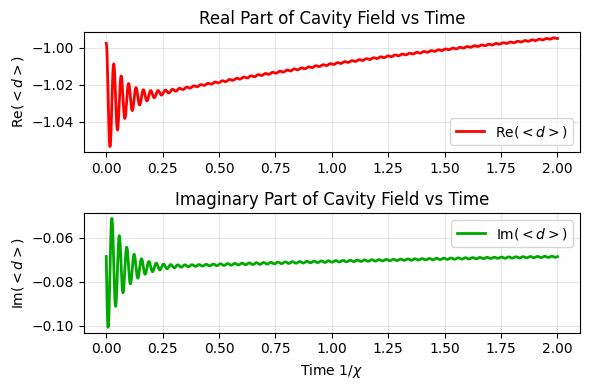

In [119]:
fig2, axes2 = plt.subplots(2, 1, figsize=(6, 4))

# Real part vs time
axes2[0].plot(tlist, np.real(d_exp), color='#FF0000', linewidth=2, label= "Re($<d>$)")
axes2[0].set_ylabel(r'Re($<d >$)')
axes2[0].legend()
axes2[0].grid(True, alpha=0.3)
axes2[0].set_title('Real Part of Cavity Field vs Time')

# Imaginary part vs time
axes2[1].plot(tlist, np.imag(d_exp), color='#00AA00', linewidth=2, label= "Im($<d>$)")
axes2[1].set_xlabel(r'Time $1/\chi$')
axes2[1].set_ylabel(r'Im($<d >$)')
axes2[1].legend()
axes2[1].grid(True, alpha=0.3)
axes2[1].set_title('Imaginary Part of Cavity Field vs Time')

plt.tight_layout()
plt.show()

Analyzing oscillation frequencies in χ units...
eff_coupling = 6.3 MHz = 1.0 χ
Time range: 0.0 to 2.0 μs



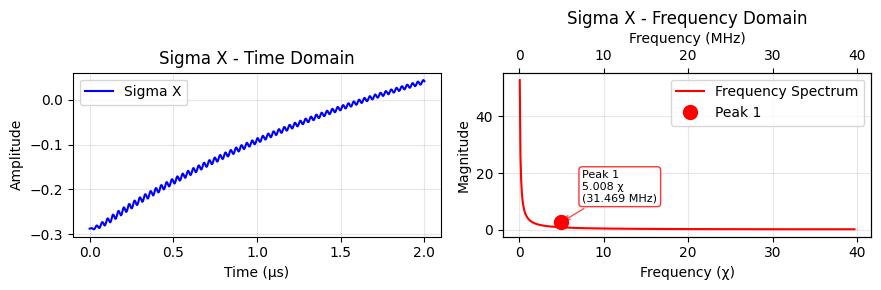


Sigma X FREQUENCY ANALYSIS
eff_coupling = 6.3 MHz = 1.0 χ
Sampling frequency: 499.50 MHz = 79.50 χ
Nyquist frequency: 249.75 MHz = 39.75 χ
Number of peaks detected: 1

Top 1 dominant frequencies:
  Peak 1: 5.008367 χ = 31.468500 MHz (magnitude: 2.678527)


IndexError: arrays used as indices must be of integer (or boolean) type

In [121]:

def analyze_oscillations_chi_units(tlist_mus, data, eff_coupling, signal_name="Signal", num_peaks=3):
    """
    Analyze oscillation frequencies in units of χ (effective coupling)
    """
    # Convert time from microseconds to seconds for frequency analysis
    t_seconds = tlist_mus * 1e-6
    
    # Remove any DC offset
    data_detrended = data - np.mean(data)
    
    # Sampling frequency in Hz (since time is in seconds)
    dt_seconds = t_seconds[1] - t_seconds[0]
    fs_Hz = 1.0 / dt_seconds
    
    # Perform FFT
    n = len(data_detrended)
    fft_result = np.fft.fft(data_detrended)
    freqs_Hz = np.fft.fftfreq(n, dt_seconds)
    
    # Convert to units of χ (eff_coupling)
    # χ = eff_coupling (in Hz), so frequency in χ units = frequency_Hz / χ
    freqs_chi = freqs_Hz / eff_coupling
    
    # Get magnitude spectrum (only positive frequencies)
    positive_freq_idx = freqs_chi > 0
    freqs_positive_chi = freqs_chi[positive_freq_idx]
    magnitude = np.abs(fft_result[positive_freq_idx])
    
    # Enhanced peak detection
    def find_multiple_peaks(magnitude, threshold_ratio=0.05, min_distance=5):
        threshold = threshold_ratio * np.max(magnitude)
        peaks = []
        
        for i in range(1, len(magnitude)-1):
            if (magnitude[i] > magnitude[i-1] and 
                magnitude[i] > magnitude[i+1] and 
                magnitude[i] > threshold):
                
                valid_peak = True
                for peak_idx in peaks:
                    if abs(i - peak_idx) < min_distance:
                        if magnitude[i] > magnitude[peak_idx]:
                            peaks.remove(peak_idx)
                        else:
                            valid_peak = False
                        break
                
                if valid_peak:
                    peaks.append(i)
        
        return np.array(peaks)
    
    peak_indices = find_multiple_peaks(magnitude)
    dominant_freqs_chi = freqs_positive_chi[peak_indices]
    dominant_magnitudes = magnitude[peak_indices]
    
    # Also convert to MHz for reference
    dominant_freqs_MHz = dominant_freqs_chi * (eff_coupling / 1e6)
    
    # Sort by magnitude
    if len(dominant_freqs_chi) > 0:
        sort_idx = np.argsort(dominant_magnitudes)[::-1]
        dominant_freqs_chi = dominant_freqs_chi[sort_idx]
        dominant_freqs_MHz = dominant_freqs_MHz[sort_idx]
        dominant_magnitudes = dominant_magnitudes[sort_idx]
    
    # Create side-by-side plots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 3))
    
    # Left plot: Time domain
    ax1.plot(tlist_mus, data, 'b-', linewidth=1.5, label=f'{signal_name}')
    ax1.set_xlabel('Time (μs)')
    ax1.set_ylabel('Amplitude')
    ax1.set_title(f'{signal_name} - Time Domain')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Right plot: Frequency domain in χ units
    ax2.plot(freqs_positive_chi, magnitude, 'r-', linewidth=1.5, label='Frequency Spectrum')
    
    # Color scheme for different peaks
    colors = ['red', 'blue', 'green', 'orange', 'purple']
    
    if len(dominant_freqs_chi) > 0:
        for i, (freq_chi, mag) in enumerate(zip(dominant_freqs_chi, dominant_magnitudes)):
            if i < len(colors):
                color = colors[i]
            else:
                color = 'black'
            
            freq_MHz = dominant_freqs_MHz[i]
            
            ax2.plot(freq_chi, mag, 'o', color=color, markersize=10, 
                    label=f'Peak {i+1}' if i < 5 else f'Peak {i+1}')
            
            ax2.annotate(f'Peak {i+1}\n{freq_chi:.3f} χ\n({freq_MHz:.3f} MHz)', 
                        xy=(freq_chi, mag), xytext=(15, 15), 
                        textcoords='offset points', fontsize=8,
                        arrowprops=dict(arrowstyle='->', color=color, alpha=0.7),
                        bbox=dict(boxstyle="round,pad=0.3", fc="white", ec=color, alpha=0.8))
    
    ax2.set_xlabel('Frequency (χ)')
    ax2.set_ylabel('Magnitude')
    ax2.set_title(f'{signal_name} - Frequency Domain')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # Add secondary x-axis for MHz on frequency plot
    ax2_twin = ax2.twiny()
    ax2_twin.set_xlim(ax2.get_xlim())
    ax2_twin.set_xlabel('Frequency (MHz)')
    
    plt.tight_layout()
    plt.show()
    
    # Print results
    print(f"\n{'='*60}")
    print(f"{signal_name} FREQUENCY ANALYSIS")
    print(f"{'='*60}")
    print(f"eff_coupling = {eff_coupling/1e6:.1f} MHz = 1.0 χ")
    print(f"Sampling frequency: {fs_Hz/1e6:.2f} MHz = {fs_Hz/eff_coupling:.2f} χ")
    print(f"Nyquist frequency: {fs_Hz/2e6:.2f} MHz = {fs_Hz/(2*eff_coupling):.2f} χ")
    print(f"Number of peaks detected: {len(dominant_freqs_chi)}")
    
    if len(dominant_freqs_chi) > 0:
        print(f"\nTop {min(num_peaks, len(dominant_freqs_chi))} dominant frequencies:")
        for i, (freq_chi, freq_MHz, mag) in enumerate(zip(
            dominant_freqs_chi[:num_peaks], 
            dominant_freqs_MHz[:num_peaks], 
            dominant_magnitudes[:num_peaks])):
            
            print(f"  Peak {i+1}: {freq_chi:.6f} χ = {freq_MHz:.6f} MHz (magnitude: {mag:.6f})")
            
        # Show frequency relationships
        if len(dominant_freqs_chi) >= 2:
            print(f"\nFrequency relationships:")
            for i in range(1, min(3, len(dominant_freqs_chi))):
                ratio = dominant_freqs_chi[i] / dominant_freqs_chi[0]
                diff = dominant_freqs_chi[i] - dominant_freqs_chi[0]
                print(f"  Peak {i+1}/Peak 1 = {ratio:.3f} (difference: {diff:.3f} χ)")
                
                # Common physical interpretations
                if abs(ratio - 2.0) < 0.2:
                    print(f"        → Likely second harmonic")
                elif abs(ratio - 0.5) < 0.1:
                    print(f"        → Likely subharmonic")
                elif abs(ratio - 1.5) < 0.2:
                    print(f"        → Possible 3:2 resonance")
    
    return dominant_freqs_chi, dominant_freqs_MHz, dominant_magnitudes

tlist_mus = tlist

print("Analyzing oscillation frequencies in χ units...")
print(f"eff_coupling = {eff_coupling/1e6:.1f} MHz = 1.0 χ")
print(f"Time range: {tlist_mus[0]:.1f} to {tlist_mus[-1]:.1f} μs\n")

# Analyze all signals
freqs_x_chi, freqs_x_MHz, mags_x = analyze_oscillations_chi_units(
    tlist_mus, x_hamiltonian7, eff_coupling, "Sigma X")

freqs_z_chi, freqs_z_MHz, mags_z = analyze_oscillations_chi_units(
    tlist_mus, z_hamiltonian7, eff_coupling, "Sigma Z")

freqs_photons_chi, freqs_photons_MHz, mags_photons = analyze_oscillations_chi_units(
    tlist_mus, photon_number, eff_coupling, "Photon Number")

freqs_real_d_chi, freqs_real_d_MHz, mags_real_d = analyze_oscillations_chi_units(
    tlist_mus, np.real(d_exp), eff_coupling, "Re(<d>)")

freqs_imag_d_chi, freqs_imag_d_MHz, mags_imag_d = analyze_oscillations_chi_units(
    tlist_mus, np.imag(d_exp), eff_coupling, "Im(<d>)")

FILTERING FREQUENCIES: [1.987447] χ

Processing Sigma X...

Filtering results for Sigma X:
Removed frequencies: [1.987447] χ
Original power: 140182.520648
Removed power: 2174.523243 (1.6%)
Remaining power: 138007.997405 (98.4%)


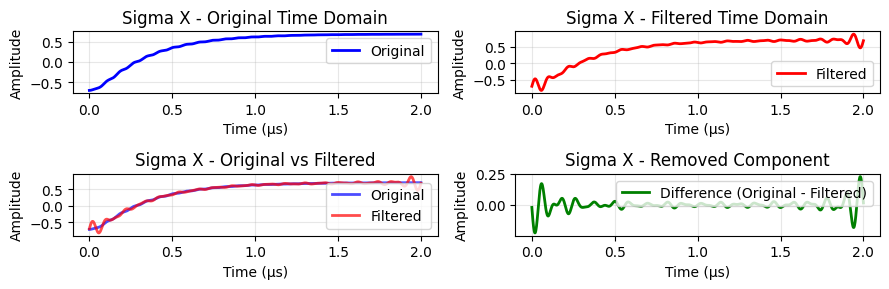

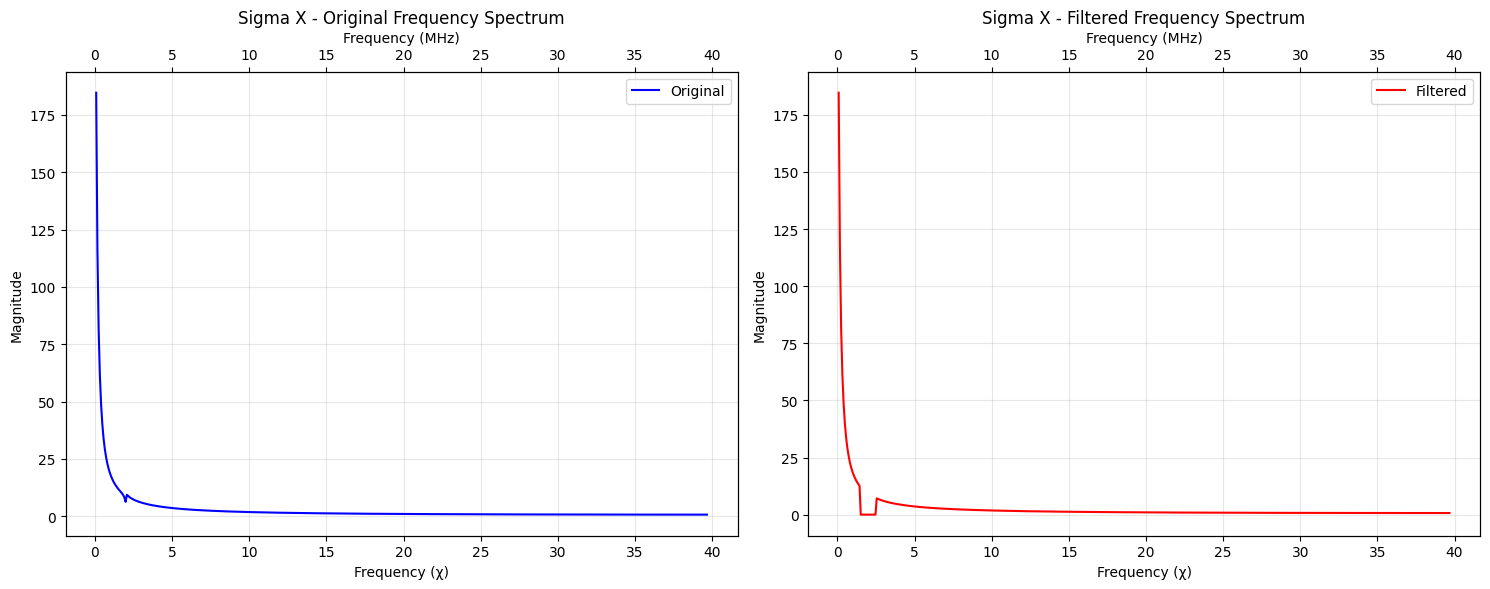


Processing Sigma Z...

Filtering results for Sigma Z:
Removed frequencies: [1.987447] χ
Original power: 144635.049707
Removed power: 2417.672452 (1.7%)
Remaining power: 142217.377255 (98.3%)


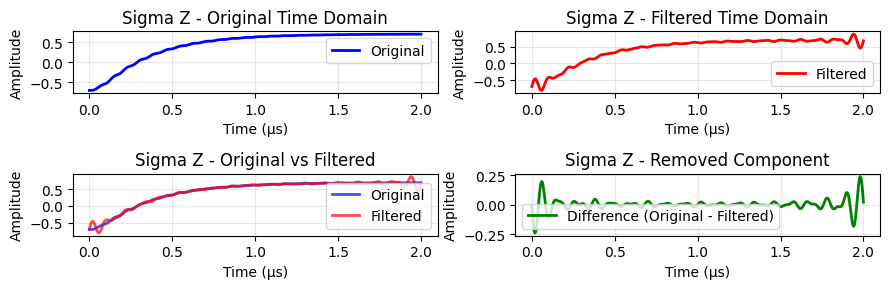

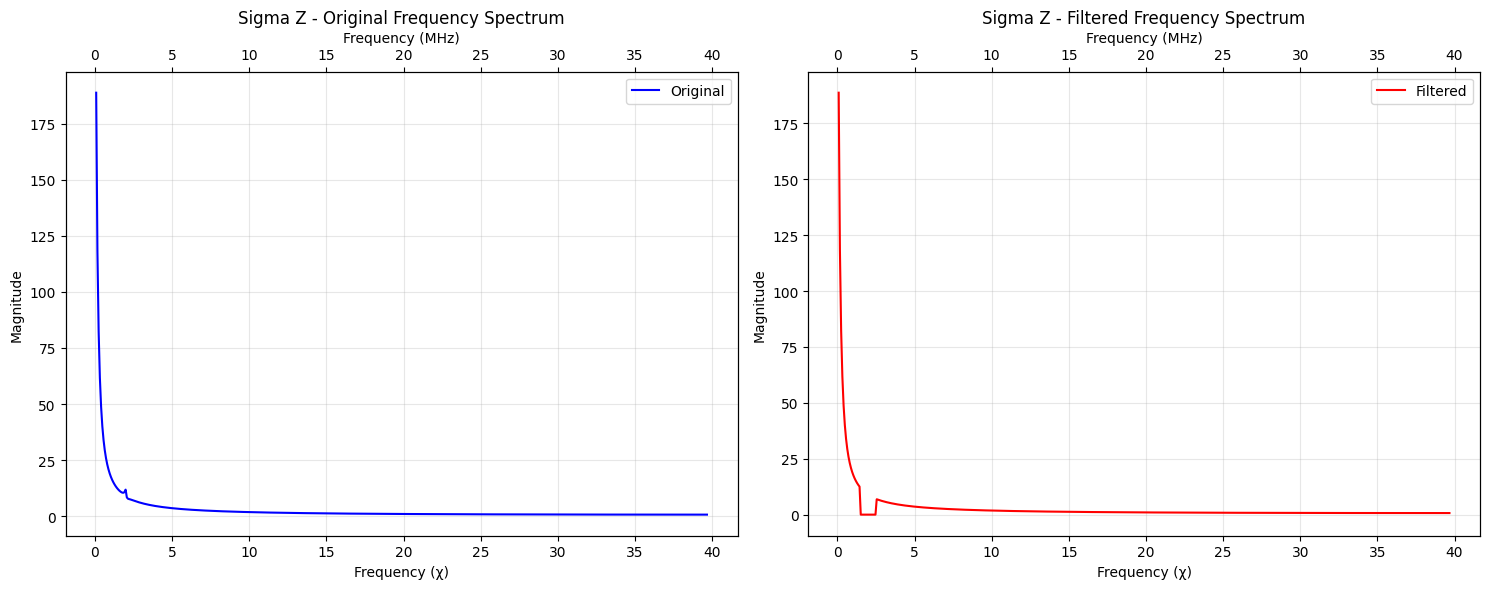


Processing Photon Number...

Filtering results for Photon Number:
Removed frequencies: [1.987447] χ
Original power: 6117.064964
Removed power: 115.234949 (1.9%)
Remaining power: 6001.830016 (98.1%)


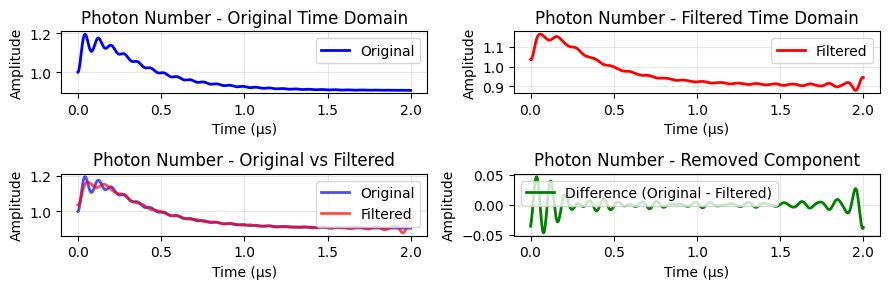

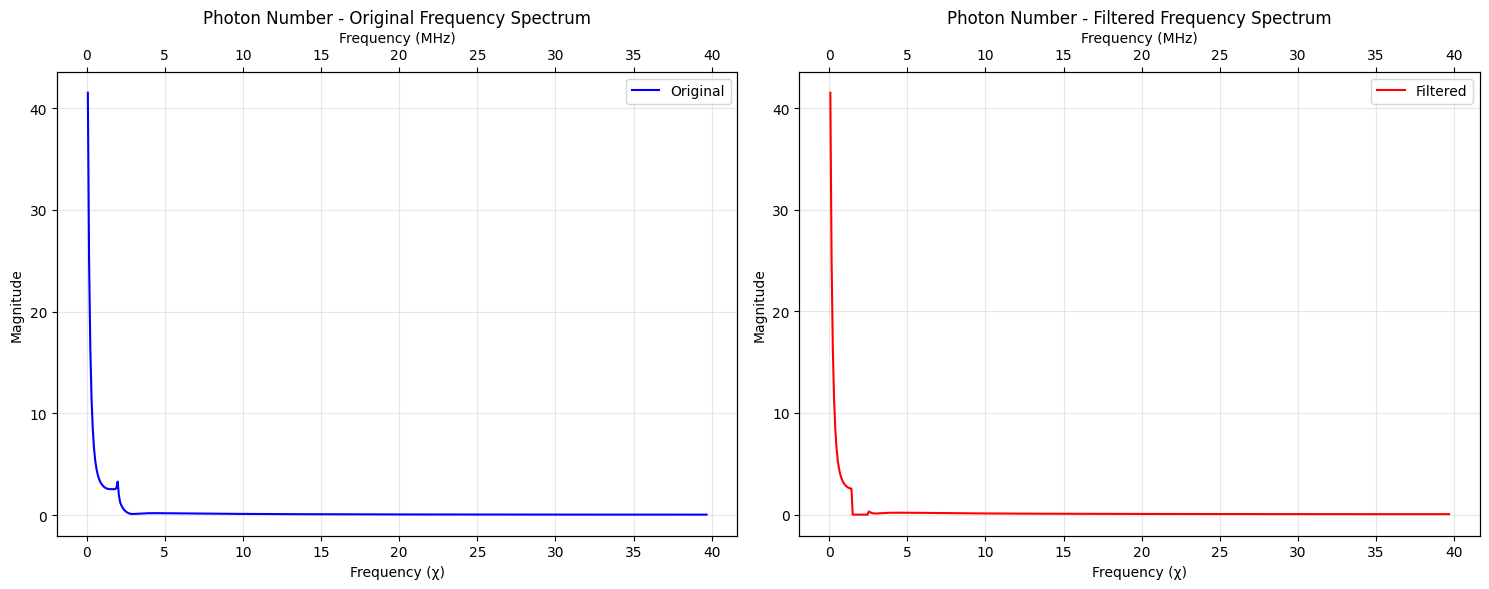


Processing Re(<d>)...

Filtering results for Re(<d>):
Removed frequencies: [1.987447] χ
Original power: 744.072340
Removed power: 23.982764 (3.2%)
Remaining power: 720.089576 (96.8%)


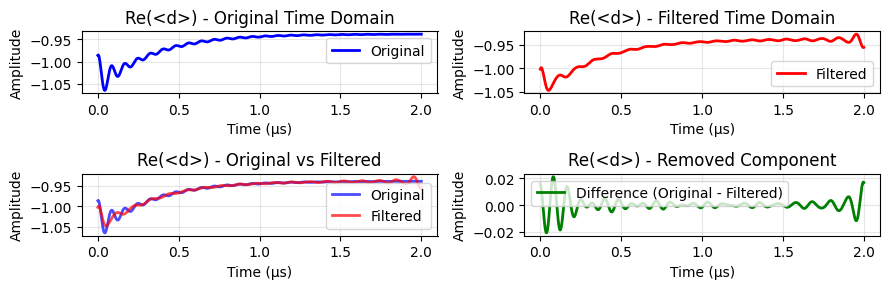

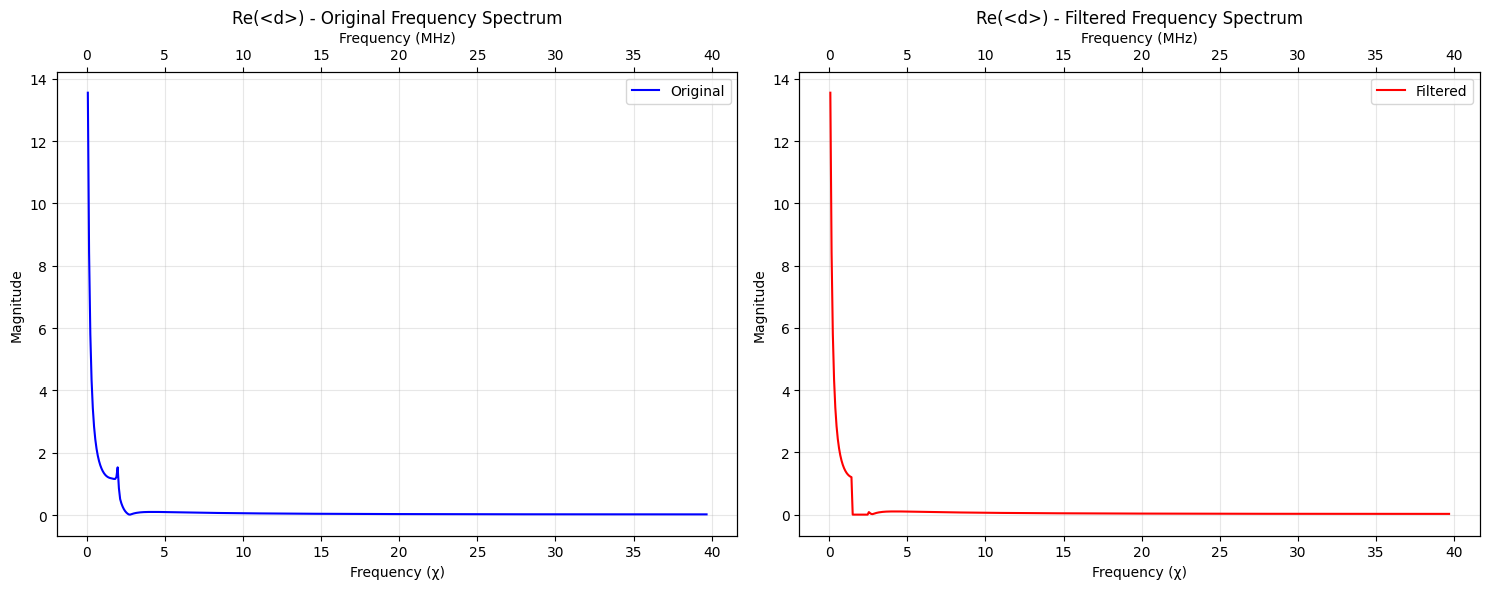


Processing Im(<d>)...

Filtering results for Im(<d>):
Removed frequencies: [1.987447] χ
Original power: 204.374370
Removed power: 27.970289 (13.7%)
Remaining power: 176.404080 (86.3%)


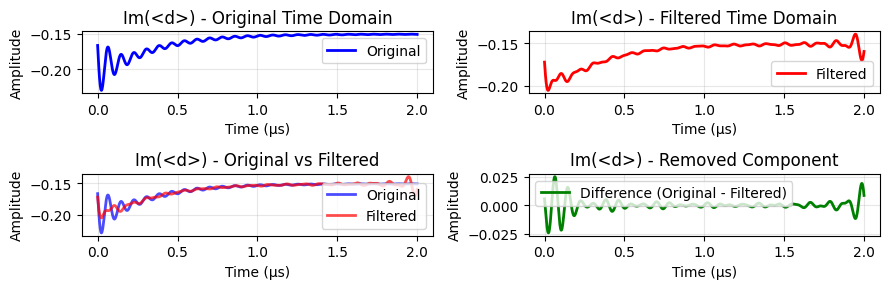

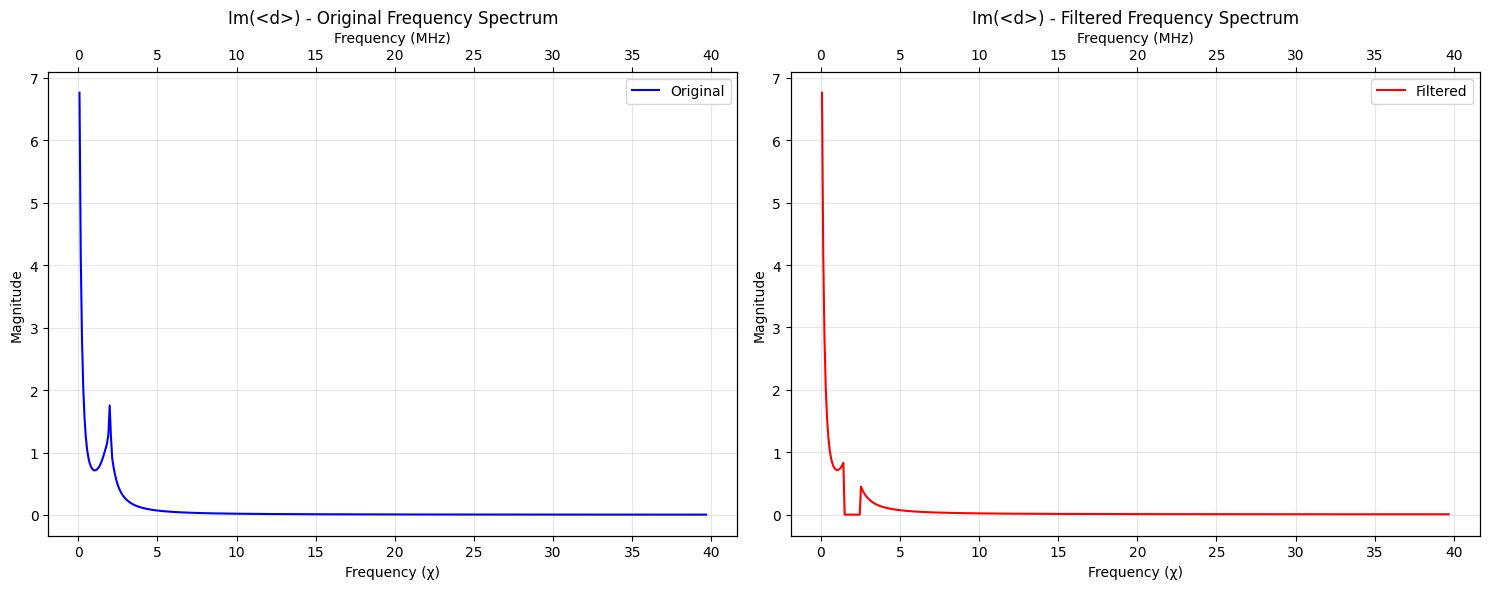


Filtered signals are available in 'filtered_signals' dictionary
Available filtered signals: ['Sigma X', 'Sigma Z', 'Photon Number', 'Re(<d>)', 'Im(<d>)']


In [91]:
def filter_frequency(tlist_mus, data, eff_coupling, frequencies_to_remove_chi, signal_name="Signal"):
    """
    Remove specific frequencies from the signal and see the resulting dynamics
    frequencies_to_remove_chi: list of frequencies in χ units to remove
    """
    # Convert time from microseconds to seconds for FFT
    t_seconds = tlist_mus * 1e-6
    
    # Remove DC offset
    data_detrended = data - np.mean(data)
    
    # Sampling frequency in Hz
    dt_seconds = t_seconds[1] - t_seconds[0]
    fs_Hz = 1.0 / dt_seconds
    
    # Perform FFT
    n = len(data_detrended)
    fft_result = np.fft.fft(data_detrended)
    freqs_Hz = np.fft.fftfreq(n, dt_seconds)
    
    # Convert to units of χ
    freqs_chi = freqs_Hz / eff_coupling
    
    # Create a mask to remove specified frequencies
    mask = np.ones_like(fft_result, dtype=bool)
    
    # Convert frequencies to remove from χ units to Hz
    frequencies_to_remove_Hz = [freq_chi * eff_coupling for freq_chi in frequencies_to_remove_chi]
    
    # Remove frequencies within a small window around each target frequency
    removal_width_Hz = 0.5*eff_coupling  # 100 kHz window
    
    for target_freq_Hz in frequencies_to_remove_Hz:
        # Find indices of frequencies to remove
        freq_indices_to_remove = np.where(
            (np.abs(freqs_Hz - target_freq_Hz) < removal_width_Hz) | 
            (np.abs(freqs_Hz + target_freq_Hz) < removal_width_Hz)  # Also remove negative frequencies
        )[0]
        mask[freq_indices_to_remove] = False
    
    # Apply the filter
    filtered_fft = fft_result.copy()
    filtered_fft[~mask] = 0
    
    # Inverse FFT to get filtered time signal
    filtered_data = np.fft.ifft(filtered_fft).real
    filtered_data += np.mean(data)  # Add back DC offset
    
    # Calculate how much power was removed
    original_power = np.sum(np.abs(fft_result)**2)
    removed_power = np.sum(np.abs(fft_result[~mask])**2)
    remaining_power = np.sum(np.abs(filtered_fft)**2)
    
    print(f"\nFiltering results for {signal_name}:")
    print(f"Removed frequencies: {frequencies_to_remove_chi} χ")
    print(f"Original power: {original_power:.6f}")
    print(f"Removed power: {removed_power:.6f} ({removed_power/original_power*100:.1f}%)")
    print(f"Remaining power: {remaining_power:.6f} ({remaining_power/original_power*100:.1f}%)")
    
    return filtered_data, filtered_fft, mask

def compare_original_vs_filtered(tlist_mus, original_data, filtered_data, signal_name="Signal"):
    """
    Compare original and filtered signals
    """
    fig, axes = plt.subplots(2, 2, figsize=(9, 3))
    
    # Top left: Original time domain
    axes[0, 0].plot(tlist_mus, original_data, 'b-', linewidth=2, label='Original')
    axes[0, 0].set_xlabel('Time (μs)')
    axes[0, 0].set_ylabel('Amplitude')
    axes[0, 0].set_title(f'{signal_name} - Original Time Domain')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # Top right: Filtered time domain
    axes[0, 1].plot(tlist_mus, filtered_data, 'r-', linewidth=2, label='Filtered')
    axes[0, 1].set_xlabel('Time (μs)')
    axes[0, 1].set_ylabel('Amplitude')
    axes[0, 1].set_title(f'{signal_name} - Filtered Time Domain')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    
    # Bottom left: Both signals overlaid
    axes[1, 0].plot(tlist_mus, original_data, 'b-', linewidth=2, label='Original', alpha=0.7)
    axes[1, 0].plot(tlist_mus, filtered_data, 'r-', linewidth=2, label='Filtered', alpha=0.7)
    axes[1, 0].set_xlabel('Time (μs)')
    axes[1, 0].set_ylabel('Amplitude')
    axes[1, 0].set_title(f'{signal_name} - Original vs Filtered')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
    
    # Bottom right: Difference
    difference = original_data - filtered_data
    axes[1, 1].plot(tlist_mus, difference, 'g-', linewidth=2, label='Difference (Original - Filtered)')
    axes[1, 1].set_xlabel('Time (μs)')
    axes[1, 1].set_ylabel('Amplitude')
    axes[1, 1].set_title(f'{signal_name} - Removed Component')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    return fig

def analyze_filtered_frequencies(tlist_mus, original_data, filtered_data, eff_coupling, signal_name="Signal"):
    """
    Analyze the frequency content of original vs filtered signals
    """
    # Convert time to seconds
    t_seconds = tlist_mus * 1e-6
    dt_seconds = t_seconds[1] - t_seconds[0]
    
    # Remove DC offset
    original_detrended = original_data - np.mean(original_data)
    filtered_detrended = filtered_data - np.mean(filtered_data)
    
    # FFT of both signals
    n = len(original_data)
    original_fft = np.fft.fft(original_detrended)
    filtered_fft = np.fft.fft(filtered_detrended)
    
    freqs_Hz = np.fft.fftfreq(n, dt_seconds)
    freqs_chi = freqs_Hz / eff_coupling
    
    # Positive frequencies only
    pos_mask = freqs_chi > 0
    freqs_pos_chi = freqs_chi[pos_mask]
    original_magnitude = np.abs(original_fft[pos_mask])
    filtered_magnitude = np.abs(filtered_fft[pos_mask])
    
    # Plot frequency comparison
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Left: Original frequency spectrum
    ax1.plot(freqs_pos_chi, original_magnitude, 'b-', linewidth=1.5, label='Original')
    ax1.set_xlabel('Frequency (χ)')
    ax1.set_ylabel('Magnitude')
    ax1.set_title(f'{signal_name} - Original Frequency Spectrum')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Right: Filtered frequency spectrum
    ax2.plot(freqs_pos_chi, filtered_magnitude, 'r-', linewidth=1.5, label='Filtered')
    ax2.set_xlabel('Frequency (χ)')
    ax2.set_ylabel('Magnitude')
    ax2.set_title(f'{signal_name} - Filtered Frequency Spectrum')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # Add MHz axes
    for ax in [ax1, ax2]:
        ax_twin = ax.twiny()
        ax_twin.set_xlim(ax.get_xlim())
        ax_twin.set_xlabel('Frequency (MHz)')
    
    plt.tight_layout()
    plt.show()

# Main function to filter specific frequencies
def filter_and_analyze_all_signals(tlist_mus, signals_dict, eff_coupling, frequencies_to_remove_chi):
    """
    Filter specified frequencies from all signals and analyze the results
    """
    print("="*70)
    print(f"FILTERING FREQUENCIES: {frequencies_to_remove_chi} χ")
    print("="*70)
    
    filtered_signals = {}
    
    for signal_name, data in signals_dict.items():
        print(f"\nProcessing {signal_name}...")
        
        # Filter the signal
        filtered_data, filtered_fft, mask = filter_frequency(
            tlist_mus, data, eff_coupling, frequencies_to_remove_chi, signal_name)
        
        # Compare original vs filtered
        compare_original_vs_filtered(tlist_mus, data, filtered_data, signal_name)
        
        # Analyze frequency content
        analyze_filtered_frequencies(tlist_mus, data, filtered_data, eff_coupling, signal_name)
        
        # Store filtered signal
        filtered_signals[signal_name] = filtered_data
    
    return filtered_signals

# Your parameters
eff_coupling = 2*np.pi*(1)*10**6

# Dictionary of your signals
signals_dict = {
    "Sigma X": x_hamiltonian7,
    "Sigma Z": z_hamiltonian7,
    "Photon Number": photon_number,
    "Re(<d>)": np.real(d_exp),
    "Im(<d>)": np.imag(d_exp)
}

# Example: Remove the main oscillation frequency (replace with your actual frequency)
# First run the frequency analysis to find the dominant frequencies, then use them here
dominant_freqs_chi = [1.987447]  # Replace with your actual frequencies in χ units

# Filter the frequencies
filtered_signals = filter_and_analyze_all_signals(
    tlist_mus, signals_dict, eff_coupling, dominant_freqs_chi)

# You can now use filtered_signals for further analysis
print("\nFiltered signals are available in 'filtered_signals' dictionary")
print("Available filtered signals:", list(filtered_signals.keys()))

In [122]:
### Cavity field non polaron.-

cavity_photon_number = 10**(input_power/10)
qubit_detuning = qubit_targetz + eff_coupling*(2*cavity_photon_number + 1) 
qubit_detuning_lamb_shift = qubit_detuning - eff_coupling*(2*cavity_photon_number + 1)
cavity_detuning = (qubit_detuning_lamb_shift**2 + rabi_freq**2)**.5
cavity_drive_amplitude = np.real((cavity_photon_number * (cavity_detuning**2 + .25*cavity_diss_rate**2))**.5)
cavity_field = cavity_drive_amplitude/(-cavity_detuning + .5j*cavity_diss_rate)

cavity_state_np = coherent(N, cavity_field)
rho_cavity_np = cavity_state_np@cavity_state_np.dag()

cavity_dynamics = np.array([ptrace(i, 0) for i in full_dynamics])

non_polaron_fid = np.array([fidelity(rho_cavity_np, i) for i in cavity_dynamics])

cavity_field_e = cavity_drive_amplitude/(-(cavity_detuning + eff_coupling) + .5j*cavity_diss_rate)
cavity_field_g = cavity_drive_amplitude/(-(cavity_detuning - eff_coupling) + .5j*cavity_diss_rate)



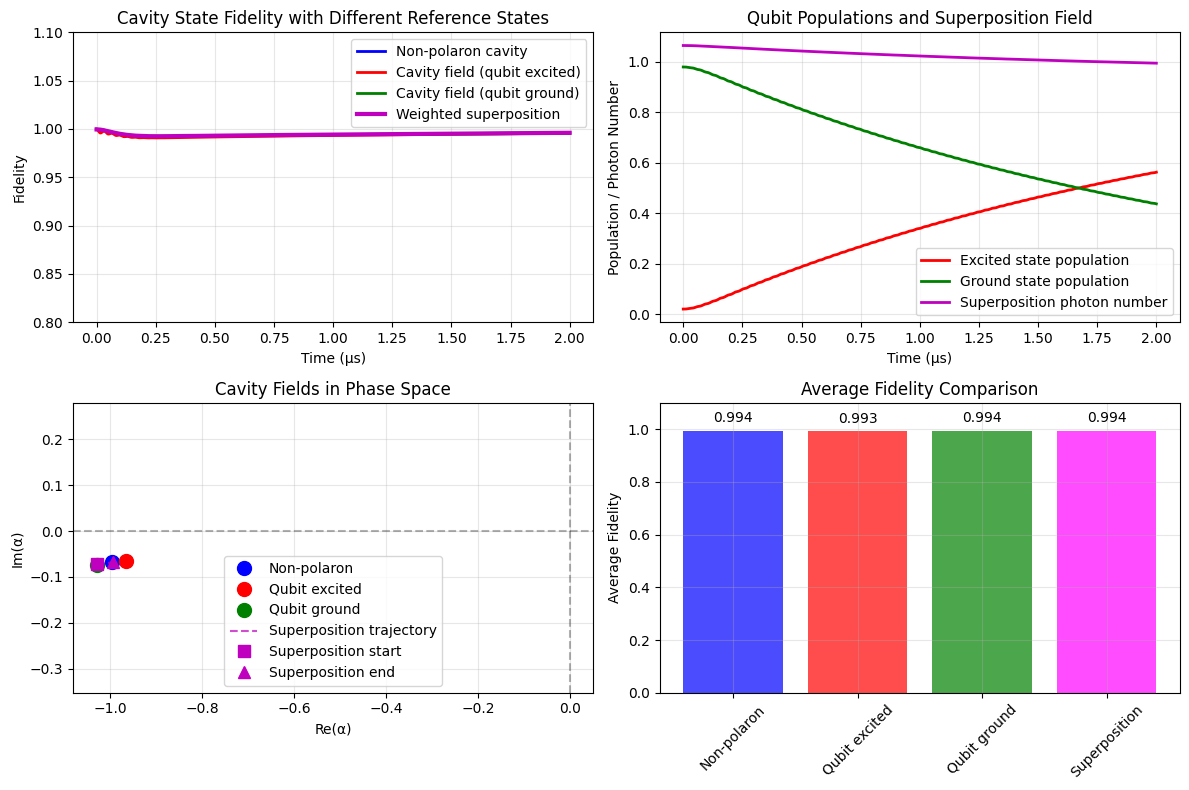

=== CAVITY FIELD INFORMATION ===
Non-polaron cavity field: α = -0.998-0.068j
  Mean photon number: 1.000
Cavity field (qubit excited): α = -0.967-0.064j
  Mean photon number: 0.939
Cavity field (qubit ground): α = -1.030-0.073j
  Mean photon number: 1.067
Superposition field range: α = -1.029-0.073j to -0.995-0.068j
  Photon number range: 1.064 to 0.994

=== FIDELITY SUMMARY ===
Non-polaron cavity fidelity: max = 1.0000, avg = 0.9943
Qubit excited cavity fidelity: max = 0.9995, avg = 0.9934
Qubit ground cavity fidelity: max = 0.9995, avg = 0.9942
Superposition fidelity: max = 0.9995, avg = 0.9945

Best matching reference state (by average fidelity): Weighted superposition (avg fidelity = 0.9945)
Best matching reference state (by maximum fidelity): Non-polaron cavity (max fidelity = 1.0000)

=== DETAILED FIDELITY STATISTICS ===
Non-polaron:
  Average: 0.9943
  Maximum: 1.0000
  Minimum: 0.9921
  Std dev: 0.0014
Qubit excited:
  Average: 0.9934
  Maximum: 0.9995
  Minimum: 0.9907
  Std d

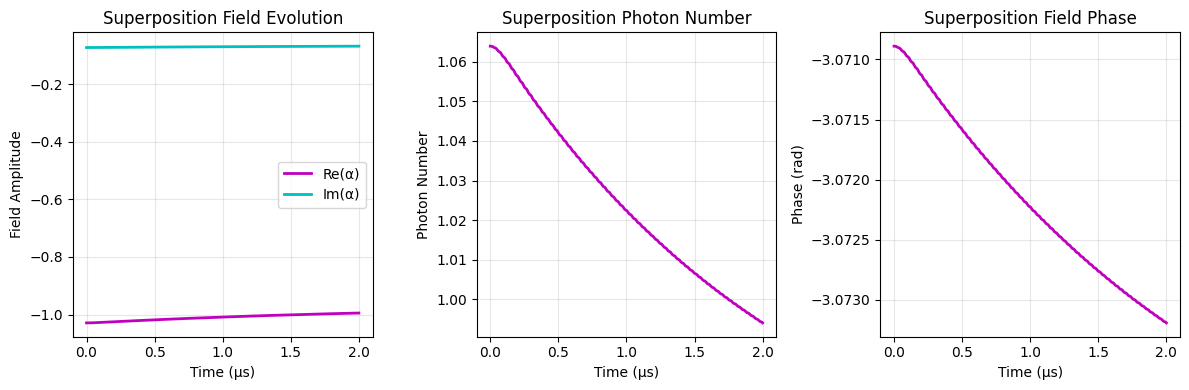

In [123]:
# Cavity field non polaron
cavity_photon_number = 10**(input_power/10)
qubit_detuning = qubit_targetz + eff_coupling*(2*cavity_photon_number + 1) 
qubit_detuning_lamb_shift = qubit_detuning - eff_coupling*(2*cavity_photon_number + 1)
cavity_detuning = (qubit_detuning_lamb_shift**2 + rabi_freq**2)**.5
cavity_drive_amplitude = np.real((cavity_photon_number * (cavity_detuning**2 + .25*cavity_diss_rate**2))**.5)
cavity_field = cavity_drive_amplitude/(-cavity_detuning + .5j*cavity_diss_rate)

# Non-polaron cavity state
cavity_state_np = coherent(N, cavity_field)
rho_cavity_np = cavity_state_np @ cavity_state_np.dag()

# Get cavity dynamics by tracing out qubit
cavity_dynamics = np.array([ptrace(i, 0) for i in full_dynamics])

# Fidelity with non-polaron cavity state
non_polaron_fid = np.array([fidelity(rho_cavity_np, i) for i in cavity_dynamics])

# Calculate the other two cavity fields
cavity_field_e = cavity_drive_amplitude/(-(cavity_detuning + eff_coupling) + .5j*cavity_diss_rate)
cavity_field_g = cavity_drive_amplitude/(-(cavity_detuning - eff_coupling) + .5j*cavity_diss_rate)

# Create coherent states for the other two fields
cavity_state_e = coherent(N, cavity_field_e)
cavity_state_g = coherent(N, cavity_field_g)

rho_cavity_e = cavity_state_e @ cavity_state_e.dag()
rho_cavity_g = cavity_state_g @ cavity_state_g.dag()

# Calculate fidelities with these states
fidelity_e = np.array([fidelity(rho_cavity_e, i) for i in cavity_dynamics])
fidelity_g = np.array([fidelity(rho_cavity_g, i) for i in cavity_dynamics])

# Calculate qubit populations using existing z_hamiltonian7
P_e = (1 + z_hamiltonian7) / 2
P_g = (1 - z_hamiltonian7) / 2

# Create time-dependent superposition cavity field
cavity_field_superposition = P_e * cavity_field_e + P_g * cavity_field_g

# Calculate fidelities with the superposition state at each time
fidelity_superposition = np.zeros_like(fidelity_e)
for i, (cav_rho, alpha_sup) in enumerate(zip(cavity_dynamics, cavity_field_superposition)):
    cavity_state_sup = coherent(N, alpha_sup)
    rho_cavity_sup = cavity_state_sup @ cavity_state_sup.dag()
    fidelity_superposition[i] = fidelity(rho_cavity_sup, cav_rho)

# Plot all four fidelities
plt.figure(figsize=(12, 8))

# Main fidelity plot
plt.subplot(2, 2, 1)
plt.plot(tlist_mus, non_polaron_fid, 'b-', linewidth=2, label='Non-polaron cavity')
plt.plot(tlist_mus, fidelity_e, 'r-', linewidth=2, label='Cavity field (qubit excited)')
plt.plot(tlist_mus, fidelity_g, 'g-', linewidth=2, label='Cavity field (qubit ground)')
plt.plot(tlist_mus, fidelity_superposition, 'm-', linewidth=3, label='Weighted superposition')

plt.xlabel('Time (μs)')
plt.ylabel('Fidelity')
plt.title('Cavity State Fidelity with Different Reference States')
plt.legend()
plt.grid(True, alpha=0.3)
plt.ylim(0.8, 1.1)

# Plot 2: Qubit populations and superposition field
plt.subplot(2, 2, 2)
plt.plot(tlist_mus, P_e, 'r-', linewidth=2, label='Excited state population')
plt.plot(tlist_mus, P_g, 'g-', linewidth=2, label='Ground state population')
plt.plot(tlist_mus, np.abs(cavity_field_superposition)**2, 'm-', linewidth=2, 
         label='Superposition photon number')
plt.xlabel('Time (μs)')
plt.ylabel('Population / Photon Number')
plt.title('Qubit Populations and Superposition Field')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 3: Cavity fields in phase space (including superposition trajectory)
plt.subplot(2, 2, 3)
# Plot static cavity fields
plt.plot(np.real(cavity_field), np.imag(cavity_field), 'bo', markersize=10, label='Non-polaron')
plt.plot(np.real(cavity_field_e), np.imag(cavity_field_e), 'ro', markersize=10, label='Qubit excited')
plt.plot(np.real(cavity_field_g), np.imag(cavity_field_g), 'go', markersize=10, label='Qubit ground')

# Plot superposition trajectory (sample every 10 points for clarity)
sample_indices = np.arange(0, len(cavity_field_superposition), max(1, len(cavity_field_superposition)//20))
plt.plot(np.real(cavity_field_superposition[sample_indices]), 
         np.imag(cavity_field_superposition[sample_indices]), 
         'm--', alpha=0.7, label='Superposition trajectory')

# Mark start and end of superposition trajectory
plt.plot(np.real(cavity_field_superposition[0]), np.imag(cavity_field_superposition[0]), 
         'ms', markersize=8, label='Superposition start')
plt.plot(np.real(cavity_field_superposition[-1]), np.imag(cavity_field_superposition[-1]), 
         'm^', markersize=8, label='Superposition end')

plt.axhline(0, color='k', linestyle='--', alpha=0.3)
plt.axvline(0, color='k', linestyle='--', alpha=0.3)
plt.xlabel('Re(α)')
plt.ylabel('Im(α)')
plt.title('Cavity Fields in Phase Space')
plt.legend()
plt.grid(True, alpha=0.3)
plt.axis('equal')

# Plot 4: Average fidelity comparison (CHANGED FROM MAX TO AVERAGE)
plt.subplot(2, 2, 4)
average_fidelities = [
    np.mean(non_polaron_fid), 
    np.mean(fidelity_e), 
    np.mean(fidelity_g), 
    np.mean(fidelity_superposition)
]
labels = ['Non-polaron', 'Qubit excited', 'Qubit ground', 'Superposition']
colors = ['blue', 'red', 'green', 'magenta']
bars = plt.bar(labels, average_fidelities, color=colors, alpha=0.7)
plt.ylabel('Average Fidelity')
plt.title('Average Fidelity Comparison')
plt.ylim(0, 1.1)

# Add value labels on bars
for bar, value in zip(bars, average_fidelities):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02, 
             f'{value:.3f}', ha='center', va='bottom')

plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

# Print cavity field information
print("=== CAVITY FIELD INFORMATION ===")
print(f"Non-polaron cavity field: α = {cavity_field:.3f}")
print(f"  Mean photon number: {np.abs(cavity_field)**2:.3f}")
print(f"Cavity field (qubit excited): α = {cavity_field_e:.3f}")
print(f"  Mean photon number: {np.abs(cavity_field_e)**2:.3f}")
print(f"Cavity field (qubit ground): α = {cavity_field_g:.3f}")
print(f"  Mean photon number: {np.abs(cavity_field_g)**2:.3f}")
print(f"Superposition field range: α = {cavity_field_superposition[0]:.3f} to {cavity_field_superposition[-1]:.3f}")
print(f"  Photon number range: {np.abs(cavity_field_superposition[0])**2:.3f} to {np.abs(cavity_field_superposition[-1])**2:.3f}")

# Print summary statistics (UPDATED TO SHOW BOTH MAX AND AVERAGE)
print("\n=== FIDELITY SUMMARY ===")
print(f"Non-polaron cavity fidelity: max = {np.max(non_polaron_fid):.4f}, avg = {np.mean(non_polaron_fid):.4f}")
print(f"Qubit excited cavity fidelity: max = {np.max(fidelity_e):.4f}, avg = {np.mean(fidelity_e):.4f}")
print(f"Qubit ground cavity fidelity: max = {np.max(fidelity_g):.4f}, avg = {np.mean(fidelity_g):.4f}")
print(f"Superposition fidelity: max = {np.max(fidelity_superposition):.4f}, avg = {np.mean(fidelity_superposition):.4f}")

# Which reference state gives the best match? (USING AVERAGE FIDELITY NOW)
fidelity_dict_avg = {
    "Non-polaron cavity": np.mean(non_polaron_fid),
    "Qubit excited cavity": np.mean(fidelity_e),
    "Qubit ground cavity": np.mean(fidelity_g),
    "Weighted superposition": np.mean(fidelity_superposition)
}

fidelity_dict_max = {
    "Non-polaron cavity": np.max(non_polaron_fid),
    "Qubit excited cavity": np.max(fidelity_e),
    "Qubit ground cavity": np.max(fidelity_g),
    "Weighted superposition": np.max(fidelity_superposition)
}

best_state_avg = max(fidelity_dict_avg, key=fidelity_dict_avg.get)
best_fidelity_avg = fidelity_dict_avg[best_state_avg]

best_state_max = max(fidelity_dict_max, key=fidelity_dict_max.get)
best_fidelity_max = fidelity_dict_max[best_state_max]

print(f"\nBest matching reference state (by average fidelity): {best_state_avg} (avg fidelity = {best_fidelity_avg:.4f})")
print(f"Best matching reference state (by maximum fidelity): {best_state_max} (max fidelity = {best_fidelity_max:.4f})")

# Additional detailed statistics
print(f"\n=== DETAILED FIDELITY STATISTICS ===")
for name, fid_array in [('Non-polaron', non_polaron_fid), 
                        ('Qubit excited', fidelity_e),
                        ('Qubit ground', fidelity_g),
                        ('Superposition', fidelity_superposition)]:
    print(f"{name}:")
    print(f"  Average: {np.mean(fid_array):.4f}")
    print(f"  Maximum: {np.max(fid_array):.4f}")
    print(f"  Minimum: {np.min(fid_array):.4f}")
    print(f"  Std dev: {np.std(fid_array):.4f}")

# Plot the superposition field evolution in more detail
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.plot(tlist_mus, np.real(cavity_field_superposition), 'm-', linewidth=2, label='Re(α)')
plt.plot(tlist_mus, np.imag(cavity_field_superposition), 'c-', linewidth=2, label='Im(α)')
plt.xlabel('Time (μs)')
plt.ylabel('Field Amplitude')
plt.title('Superposition Field Evolution')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 3, 2)
plt.plot(tlist_mus, np.abs(cavity_field_superposition)**2, 'm-', linewidth=2)
plt.xlabel('Time (μs)')
plt.ylabel('Photon Number')
plt.title('Superposition Photon Number')
plt.grid(True, alpha=0.3)

plt.subplot(1, 3, 3)
plt.plot(tlist_mus, np.angle(cavity_field_superposition), 'm-', linewidth=2)
plt.xlabel('Time (μs)')
plt.ylabel('Phase (rad)')
plt.title('Superposition Field Phase')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [124]:
### Add time dynamics of the coherent field.

def coherent_state_dynamics(t, initial_state, cavity_drive_amplitude, cavity_freq, cavity_diss_rate):
    cavity_field = cavity_drive_amplitude/(-(cavity_freq) + .5j*cavity_diss_rate)
    cavity_state = coherent(N, cavity_field)
    rho_cavity = cavity_state @ cavity_state.dag()
    tdynamics = np.exp(-1j*(cavity_freq*t)-cavity_diss_rate*t/2)
    return initial_state*tdynamics + rho_cavity*(1-tdynamics)

# Cavity field non polaron
cavity_photon_number = 10**(input_power/10)
qubit_detuning = qubit_targetz + eff_coupling*(2*cavity_photon_number + 1) 
qubit_detuning_lamb_shift = qubit_detuning - eff_coupling*(2*cavity_photon_number + 1)
cavity_detuning = (qubit_detuning_lamb_shift**2 + rabi_freq**2)**.5
cavity_drive_amplitude = np.real((cavity_photon_number * (cavity_detuning**2 + .25*cavity_diss_rate**2))**.5)
cavity_field = cavity_drive_amplitude/(-cavity_detuning + .5j*cavity_diss_rate)

# Non-polaron cavity state
cavity_state_np = coherent(N, cavity_field)
rho_cavity_np = cavity_state_np @ cavity_state_np.dag()

# Get cavity dynamics by tracing out qubit
cavity_dynamics = np.array([ptrace(i, 0) for i in full_dynamics])

# Fidelity with non-polaron cavity state
non_polaron_fid = np.array([fidelity(rho_cavity_np, i) for i in cavity_dynamics])

# Calculate the other two cavity fields
cavity_field_e = cavity_drive_amplitude/(-(cavity_detuning + eff_coupling) + .5j*cavity_diss_rate)
cavity_field_g = cavity_drive_amplitude/(-(cavity_detuning - eff_coupling) + .5j*cavity_diss_rate)

rho_cavity_e_t = np.array([coherent_state_dynamics(i, rho_cavity_np, cavity_drive_amplitude, cavity_detuning + eff_coupling, cavity_diss_rate) for i in tlist/1e-6])
rho_cavity_g_t = np.array([coherent_state_dynamics(i, rho_cavity_np, cavity_drive_amplitude, cavity_detuning - eff_coupling, cavity_diss_rate) for i in tlist/1e-6])
# Calculate fidelities with these states
fidelity_e = np.array([fidelity(rho_cavity_e_t[i], cavity_dynamics[i]) for i in np.arange(len(tlist))])
fidelity_e = np.array([fidelity(rho_cavity_g_t[i], cavity_dynamics[i]) for i in np.arange(len(tlist))])


In [125]:
beta = cavity_field_e - cavity_field_g
beta,beta*cavity_diss_rate/eff_coupling, np.abs(beta), rabi_freq*np.exp((-1j*np.imag(cavity_field_g*np.conj(cavity_field_e))))/eff_coupling

((0.0631699072016848+0.008722489696443542j),
 (0.2716306009672447+0.03750670569470723j),
 0.06376926377475306,
 (8.999914004769925-0.039343446038279335j))

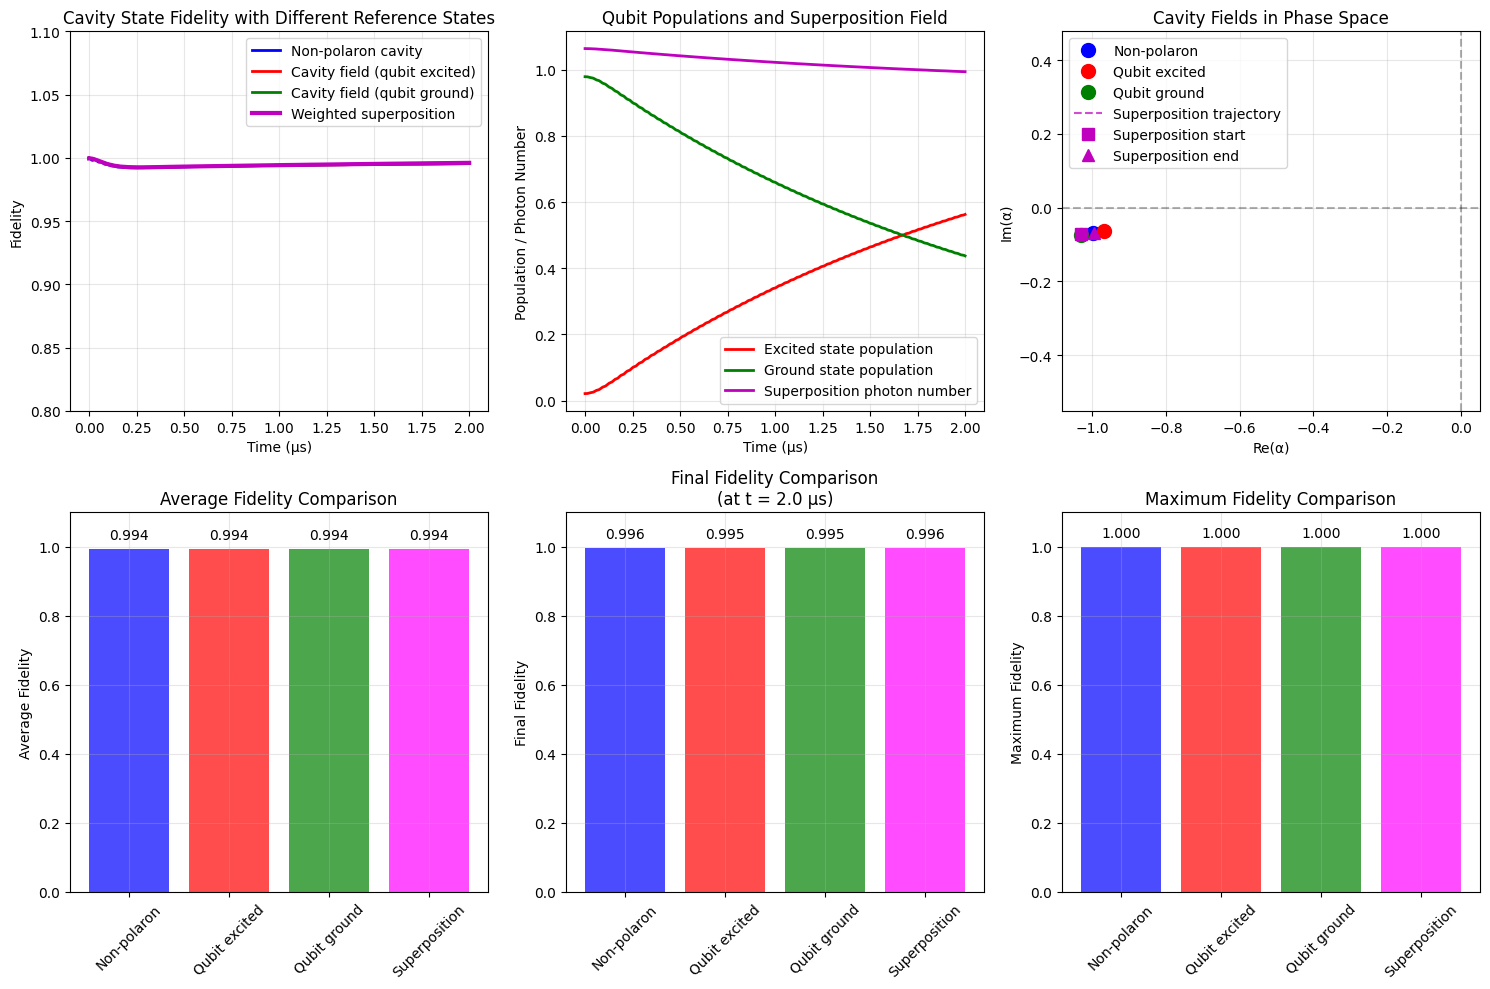

=== CAVITY FIELD INFORMATION ===
Non-polaron cavity field: α = -0.998-0.068j
  Mean photon number: 1.000
Cavity field (qubit excited): α = -0.967-0.064j
  Mean photon number: 0.939
Cavity field (qubit ground): α = -1.030-0.073j
  Mean photon number: 1.067
Superposition field range: α = -1.029-0.073j to -0.995-0.068j
  Photon number range: 1.064 to 0.994

=== FIDELITY SUMMARY ===
Non-polaron cavity fidelity: final = 0.9960, avg = 0.9943, max = 1.0000
Qubit excited cavity fidelity: final = 0.9954, avg = 0.9942, max = 1.0000
Qubit ground cavity fidelity: final = 0.9954, avg = 0.9942, max = 0.9995
Superposition fidelity: final = 0.9960, avg = 0.9945, max = 0.9995

Best matching reference state:
  By average fidelity: Weighted superposition (avg = 0.9945)
  By maximum fidelity: Non-polaron cavity (max = 1.0000)
  By final fidelity: Weighted superposition (final = 0.9960)

=== DETAILED FIDELITY STATISTICS ===
Non-polaron:
  Final: 0.9960
  Average: 0.9943
  Maximum: 1.0000
  Minimum: 0.9921


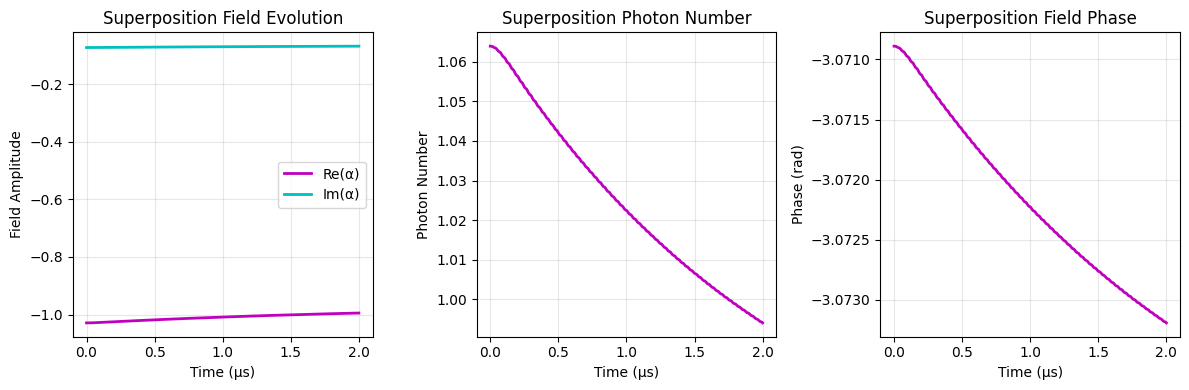

In [126]:
# Calculate qubit populations using existing z_hamiltonian7
P_e = (1 + z_hamiltonian7) / 2
P_g = (1 - z_hamiltonian7) / 2

# Create time-dependent superposition cavity field
cavity_field_superposition = P_e * cavity_field_e + P_g * cavity_field_g

# Calculate fidelities with the superposition state at each time
fidelity_superposition = np.zeros_like(fidelity_e)
for i, (cav_rho, alpha_sup) in enumerate(zip(cavity_dynamics, cavity_field_superposition)):
    cavity_state_sup = coherent(N, alpha_sup)
    rho_cavity_sup = cavity_state_sup @ cavity_state_sup.dag()
    fidelity_superposition[i] = fidelity(rho_cavity_sup, cav_rho)

# Calculate final fidelities (at last time step)
final_fidelities = [
    non_polaron_fid[-1], 
    fidelity_e[-1], 
    fidelity_g[-1], 
    fidelity_superposition[-1]
]

# Plot all four fidelities
plt.figure(figsize=(15, 10))

# Main fidelity plot
plt.subplot(2, 3, 1)
plt.plot(tlist_mus, non_polaron_fid, 'b-', linewidth=2, label='Non-polaron cavity')
plt.plot(tlist_mus, fidelity_e, 'r-', linewidth=2, label='Cavity field (qubit excited)')
plt.plot(tlist_mus, fidelity_g, 'g-', linewidth=2, label='Cavity field (qubit ground)')
plt.plot(tlist_mus, fidelity_superposition, 'm-', linewidth=3, label='Weighted superposition')

plt.xlabel('Time (μs)')
plt.ylabel('Fidelity')
plt.title('Cavity State Fidelity with Different Reference States')
plt.legend()
plt.grid(True, alpha=0.3)
plt.ylim(0.8, 1.1)

# Plot 2: Qubit populations and superposition field
plt.subplot(2, 3, 2)
plt.plot(tlist_mus, P_e, 'r-', linewidth=2, label='Excited state population')
plt.plot(tlist_mus, P_g, 'g-', linewidth=2, label='Ground state population')
plt.plot(tlist_mus, np.abs(cavity_field_superposition)**2, 'm-', linewidth=2, 
         label='Superposition photon number')
plt.xlabel('Time (μs)')
plt.ylabel('Population / Photon Number')
plt.title('Qubit Populations and Superposition Field')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 3: Cavity fields in phase space (including superposition trajectory)
plt.subplot(2, 3, 3)
# Plot static cavity fields
plt.plot(np.real(cavity_field), np.imag(cavity_field), 'bo', markersize=10, label='Non-polaron')
plt.plot(np.real(cavity_field_e), np.imag(cavity_field_e), 'ro', markersize=10, label='Qubit excited')
plt.plot(np.real(cavity_field_g), np.imag(cavity_field_g), 'go', markersize=10, label='Qubit ground')

# Plot superposition trajectory (sample every 10 points for clarity)
sample_indices = np.arange(0, len(cavity_field_superposition), max(1, len(cavity_field_superposition)//20))
plt.plot(np.real(cavity_field_superposition[sample_indices]), 
         np.imag(cavity_field_superposition[sample_indices]), 
         'm--', alpha=0.7, label='Superposition trajectory')

# Mark start and end of superposition trajectory
plt.plot(np.real(cavity_field_superposition[0]), np.imag(cavity_field_superposition[0]), 
         'ms', markersize=8, label='Superposition start')
plt.plot(np.real(cavity_field_superposition[-1]), np.imag(cavity_field_superposition[-1]), 
         'm^', markersize=8, label='Superposition end')

plt.axhline(0, color='k', linestyle='--', alpha=0.3)
plt.axvline(0, color='k', linestyle='--', alpha=0.3)
plt.xlabel('Re(α)')
plt.ylabel('Im(α)')
plt.title('Cavity Fields in Phase Space')
plt.legend()
plt.grid(True, alpha=0.3)
plt.axis('equal')

# Plot 4: Average fidelity comparison
plt.subplot(2, 3, 4)
average_fidelities = [
    np.mean(non_polaron_fid), 
    np.mean(fidelity_e), 
    np.mean(fidelity_g), 
    np.mean(fidelity_superposition)
]
labels = ['Non-polaron', 'Qubit excited', 'Qubit ground', 'Superposition']
colors = ['blue', 'red', 'green', 'magenta']
bars = plt.bar(labels, average_fidelities, color=colors, alpha=0.7)
plt.ylabel('Average Fidelity')
plt.title('Average Fidelity Comparison')
plt.ylim(0, 1.1)

# Add value labels on bars
for bar, value in zip(bars, average_fidelities):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02, 
             f'{value:.3f}', ha='center', va='bottom')

plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)

# Plot 5: Final fidelity comparison (NEW BAR CHART)
plt.subplot(2, 3, 5)
final_fidelities = [
    non_polaron_fid[-1], 
    fidelity_e[-1], 
    fidelity_g[-1], 
    fidelity_superposition[-1]
]
labels_final = ['Non-polaron', 'Qubit excited', 'Qubit ground', 'Superposition']
colors_final = ['blue', 'red', 'green', 'magenta']
bars_final = plt.bar(labels_final, final_fidelities, color=colors_final, alpha=0.7)
plt.ylabel('Final Fidelity')
plt.title('Final Fidelity Comparison\n(at t = {:.1f} μs)'.format(tlist_mus[-1]))
plt.ylim(0, 1.1)

# Add value labels on bars
for bar, value in zip(bars_final, final_fidelities):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02, 
             f'{value:.3f}', ha='center', va='bottom')

plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)

# Plot 6: Maximum fidelity comparison
plt.subplot(2, 3, 6)
max_fidelities = [
    np.max(non_polaron_fid), 
    np.max(fidelity_e), 
    np.max(fidelity_g), 
    np.max(fidelity_superposition)
]
labels_max = ['Non-polaron', 'Qubit excited', 'Qubit ground', 'Superposition']
colors_max = ['blue', 'red', 'green', 'magenta']
bars_max = plt.bar(labels_max, max_fidelities, color=colors_max, alpha=0.7)
plt.ylabel('Maximum Fidelity')
plt.title('Maximum Fidelity Comparison')
plt.ylim(0, 1.1)

# Add value labels on bars
for bar, value in zip(bars_max, max_fidelities):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02, 
             f'{value:.3f}', ha='center', va='bottom')

plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

# Print cavity field information
print("=== CAVITY FIELD INFORMATION ===")
print(f"Non-polaron cavity field: α = {cavity_field:.3f}")
print(f"  Mean photon number: {np.abs(cavity_field)**2:.3f}")
print(f"Cavity field (qubit excited): α = {cavity_field_e:.3f}")
print(f"  Mean photon number: {np.abs(cavity_field_e)**2:.3f}")
print(f"Cavity field (qubit ground): α = {cavity_field_g:.3f}")
print(f"  Mean photon number: {np.abs(cavity_field_g)**2:.3f}")
print(f"Superposition field range: α = {cavity_field_superposition[0]:.3f} to {cavity_field_superposition[-1]:.3f}")
print(f"  Photon number range: {np.abs(cavity_field_superposition[0])**2:.3f} to {np.abs(cavity_field_superposition[-1])**2:.3f}")

# Print summary statistics (UPDATED TO INCLUDE FINAL FIDELITY)
print("\n=== FIDELITY SUMMARY ===")
print(f"Non-polaron cavity fidelity: final = {non_polaron_fid[-1]:.4f}, avg = {np.mean(non_polaron_fid):.4f}, max = {np.max(non_polaron_fid):.4f}")
print(f"Qubit excited cavity fidelity: final = {fidelity_e[-1]:.4f}, avg = {np.mean(fidelity_e):.4f}, max = {np.max(fidelity_e):.4f}")
print(f"Qubit ground cavity fidelity: final = {fidelity_g[-1]:.4f}, avg = {np.mean(fidelity_g):.4f}, max = {np.max(fidelity_g):.4f}")
print(f"Superposition fidelity: final = {fidelity_superposition[-1]:.4f}, avg = {np.mean(fidelity_superposition):.4f}, max = {np.max(fidelity_superposition):.4f}")

# Which reference state gives the best match? (NOW INCLUDING FINAL FIDELITY)
fidelity_dict_avg = {
    "Non-polaron cavity": np.mean(non_polaron_fid),
    "Qubit excited cavity": np.mean(fidelity_e),
    "Qubit ground cavity": np.mean(fidelity_g),
    "Weighted superposition": np.mean(fidelity_superposition)
}

fidelity_dict_max = {
    "Non-polaron cavity": np.max(non_polaron_fid),
    "Qubit excited cavity": np.max(fidelity_e),
    "Qubit ground cavity": np.max(fidelity_g),
    "Weighted superposition": np.max(fidelity_superposition)
}

fidelity_dict_final = {
    "Non-polaron cavity": non_polaron_fid[-1],
    "Qubit excited cavity": fidelity_e[-1],
    "Qubit ground cavity": fidelity_g[-1],
    "Weighted superposition": fidelity_superposition[-1]
}

best_state_avg = max(fidelity_dict_avg, key=fidelity_dict_avg.get)
best_fidelity_avg = fidelity_dict_avg[best_state_avg]

best_state_max = max(fidelity_dict_max, key=fidelity_dict_max.get)
best_fidelity_max = fidelity_dict_max[best_state_max]

best_state_final = max(fidelity_dict_final, key=fidelity_dict_final.get)
best_fidelity_final = fidelity_dict_final[best_state_final]

print(f"\nBest matching reference state:")
print(f"  By average fidelity: {best_state_avg} (avg = {best_fidelity_avg:.4f})")
print(f"  By maximum fidelity: {best_state_max} (max = {best_fidelity_max:.4f})")
print(f"  By final fidelity: {best_state_final} (final = {best_fidelity_final:.4f})")

# Additional detailed statistics
print(f"\n=== DETAILED FIDELITY STATISTICS ===")
for name, fid_array in [('Non-polaron', non_polaron_fid), 
                        ('Qubit excited', fidelity_e),
                        ('Qubit ground', fidelity_g),
                        ('Superposition', fidelity_superposition)]:
    print(f"{name}:")
    print(f"  Final: {fid_array[-1]:.4f}")
    print(f"  Average: {np.mean(fid_array):.4f}")
    print(f"  Maximum: {np.max(fid_array):.4f}")
    print(f"  Minimum: {np.min(fid_array):.4f}")
    print(f"  Std dev: {np.std(fid_array):.4f}")

# Plot the superposition field evolution in more detail
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.plot(tlist_mus, np.real(cavity_field_superposition), 'm-', linewidth=2, label='Re(α)')
plt.plot(tlist_mus, np.imag(cavity_field_superposition), 'c-', linewidth=2, label='Im(α)')
plt.xlabel('Time (μs)')
plt.ylabel('Field Amplitude')
plt.title('Superposition Field Evolution')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 3, 2)
plt.plot(tlist_mus, np.abs(cavity_field_superposition)**2, 'm-', linewidth=2)
plt.xlabel('Time (μs)')
plt.ylabel('Photon Number')
plt.title('Superposition Photon Number')
plt.grid(True, alpha=0.3)

plt.subplot(1, 3, 3)
plt.plot(tlist_mus, np.angle(cavity_field_superposition), 'm-', linewidth=2)
plt.xlabel('Time (μs)')
plt.ylabel('Phase (rad)')
plt.title('Superposition Field Phase')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()